In [57]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
%pwd

'/home/kyudan/AnomLLM/src'

In [59]:
%cd ..
%cd src

/home/kyudan/AnomLLM
/home/kyudan/AnomLLM/src


In [60]:
%pwd

'/home/kyudan/AnomLLM/src'

In [61]:
from prompt import time_series_to_image
from utils import view_base64_image, display_messages, collect_results
from data.synthetic import SyntheticDataset

data_name = 'point'
data_dir = f'/home/kyudan/AnomLLM/data/synthetic/{data_name}/eval/'
train_dir = f'/home/kyudan/AnomLLM/data/synthetic/{data_name}/train/'
eval_dataset = SyntheticDataset(data_dir)
eval_dataset.load()
train_dataset = SyntheticDataset(train_dir)
train_dataset.load()

Loaded dataset point with 400 series.
Loaded dataset point with 400 series.


In [62]:
from utils import plot_series_and_predictions
from utils import view_base64_image, display_messages, collect_results
idx = 0
directory = f'/home/kyudan/AnomLLM/results/synthetic/{data_name}'
series = eval_dataset[idx][1].numpy() # eval dataset의 문제 series.
anomaly_locations = eval_dataset[idx][0].numpy() # eval dataset의 gt가 될 것.

raw_results = collect_results(directory, raw=True)
raw_results = {k: v[idx] for k, v in raw_results.items()}


In [63]:
anomaly_locations

array([[[485., 500.]]], dtype=float32)

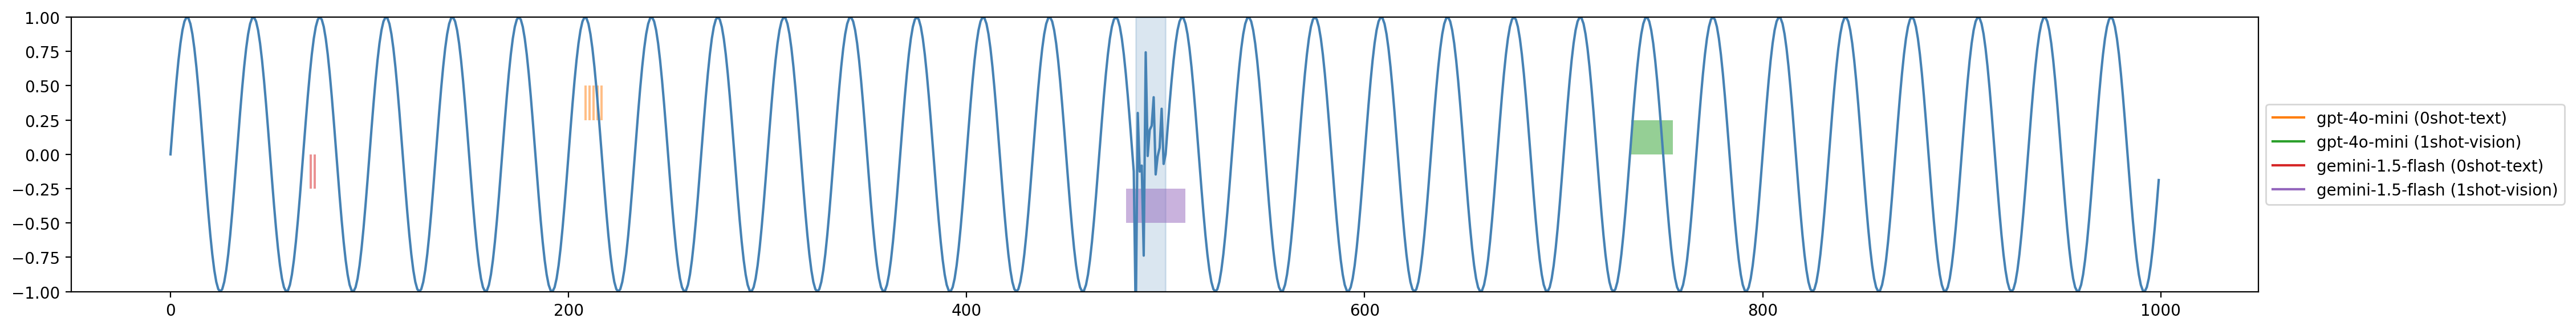

In [64]:
results = collect_results(directory)
results = {k: v[idx] for k, v in results.items()}

fig = plot_series_and_predictions(
    series=series, 
    gt_anomaly_intervals=anomaly_locations,
    anomalies=results
)

In [66]:
from utils import display_messages

display_messages(raw_results['gpt-4o-mini (0shot-text)']['request']['messages'])

{'gpt-4o-mini (0shot-text)': {'custom_id': 'point_gpt-4o-mini_0shot-text_00001',
  'request': {'messages': [{'role': 'user',
     'content': [{'type': 'text',
       'text': '0.0 0.19 0.37 0.54 0.68 0.81 0.9 0.97 1.0 0.99 0.95 0.88 0.77 0.64 0.48 0.31 0.13 -0.06 -0.25 -0.43 -0.59 -0.73 -0.84 -0.93 -0.98 -1.0 -0.98 -0.93 -0.84 -0.73 -0.59 -0.43 -0.25 -0.06 0.13 0.31 0.48 0.64 0.77 0.88 0.95 0.99 1.0 0.97 0.9 0.81 0.68 0.54 0.37 0.19 0.0 -0.19 -0.37 -0.54 -0.68 -0.81 -0.9 -0.97 -1.0 -0.99 -0.95 -0.88 -0.77 -0.64 -0.48 -0.31 -0.13 0.06 0.25 0.43 0.59 0.73 0.84 0.93 0.98 1.0 0.98 0.93 0.84 0.73 0.59 0.43 0.25 0.06 -0.13 -0.31 -0.48 -0.64 -0.77 -0.88 -0.95 -0.99 -1.0 -0.97 -0.9 -0.81 -0.68 -0.54 -0.37 -0.19 -0.0 0.19 0.37 0.54 0.68 0.81 0.9 0.97 1.0 0.99 0.95 0.88 0.77 0.64 0.48 0.31 0.13 -0.06 -0.25 -0.43 -0.59 -0.73 -0.84 -0.93 -0.98 -1.0 -0.98 -0.93 -0.84 -0.73 -0.59 -0.43 -0.25 -0.06 0.13 0.31 0.48 0.64 0.77 0.88 0.95 0.99 1.0 0.97 0.9 0.81 0.68 0.54 0.37 0.19 0.0 -0.19 -0.37 -0.54 -0.6
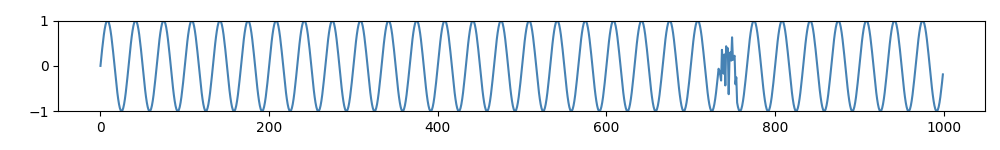
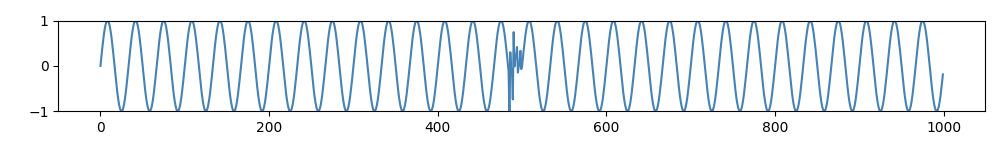
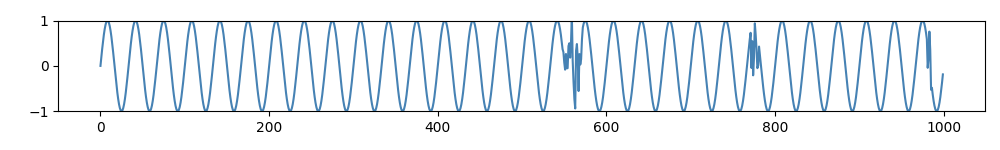
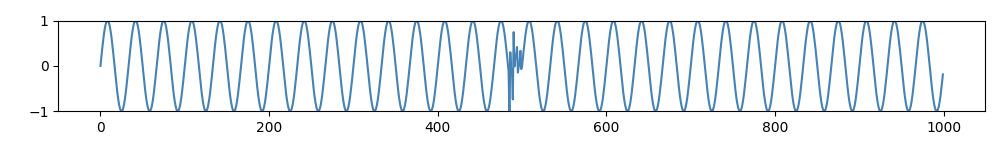

In [67]:
raw_results


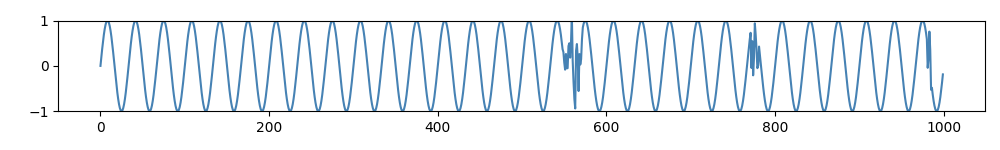
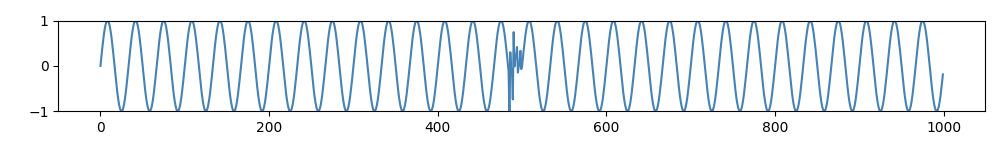

In [68]:
from utils import display_messages

display_messages(raw_results['gemini-1.5-flash (1shot-vision)']['request']['messages'])

In [69]:
print(list(raw_results.values())[0]['response'])

```json
[{"start": 208, "end": 209}, {"start": 210, "end": 211}, {"start": 212, "end": 213}, {"start": 214, "end": 215}, {"start": 216, "end": 217}]
```


In [70]:
anomaly_locations[0]

array([[485., 500.]], dtype=float32)

In [71]:
from utils import interval_to_vector
gt = interval_to_vector(anomaly_locations[0])
# interval_to_vector 를 하면 gt의 구간에 대해서 1 로 바뀜.
# 0 0 0 0 0 0 1 1 1 0 0 0 0 0 

{'start': np.float32(485.0), 'end': np.float32(500.0)}


In [72]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from affiliation.generics import convert_vector_to_events
from affiliation.metrics import pr_from_events
from utils import compute_metrics

data = {}

for name, prediction in results.items():
    metrics = compute_metrics(gt, prediction)
    data[name] = metrics

df = pd.DataFrame(data).T
df


,precision,recall,f1,affi precision,affi recall,affi f1
gpt-4o-mini (0shot-text),0.0,0.0,0.000,0.440,0.449,0.444
gpt-4o-mini (1shot-vision),0.0,0.0,0.000,0.496,0.517,0.506
gemini-1.5-flash (0shot-text),0.0,0.0,0.000,0.158,0.161,0.159
gemini-1.5-flash (1shot-vision),0.5,1.0,0.667,0.988,1.000,0.994


In [73]:
# Keep only the first four columns
df = df.iloc[:, :4].fillna(0)

In [74]:
{k: v['response'] for k, v in raw_results.items()}

{'gpt-4o-mini (0shot-text)': '```json\n[{"start": 208, "end": 209}, {"start": 210, "end": 211}, {"start": 212, "end": 213}, {"start": 214, "end": 215}, {"start": 216, "end": 217}]\n```',
 'gpt-4o-mini (1shot-vision)': '[{"start": 734, "end": 755}]',
 'gemini-1.5-flash (0shot-text)': '```json\n[{"start": 70, "end": 71}, {"start": 72, "end": 73}]\n```\n',
 'gemini-1.5-flash (1shot-vision)': '[{"start": 480, "end": 510}]'}

In [75]:
from utils import highlight_by_ranking
from IPython.core.display import HTML
styled_df = highlight_by_ranking(df.T).T
HTML(styled_df.to_html(escape=False))


,precision,recall,f1,affi precision
gpt-4o-mini (0shot-text),0.00,0.00,0.00,44.00
gpt-4o-mini (1shot-vision),0.00,0.00,0.00,49.60
gemini-1.5-flash (0shot-text),0.00,0.00,0.00,15.80
gemini-1.5-flash (1shot-vision),50.00,100.00,66.70,98.80


In [76]:
results = collect_results(directory)

In [77]:
import numpy as np
import pandas as pd
from tqdm import trange
from utils import compute_metrics, interval_to_vector

# Initialize dictionary to store results
metric_names = ['precision', 'recall', 'f1', 'affi precision', 'affi recall', 'affi f1']

results_dict = {
    key: [[] for _ in metric_names] for key in results.keys()
}

# Initialize DataFrame to store results
df_list = []

for i in trange(0, 400):
    series = eval_dataset[idx][1].numpy()
    anomaly_locations = eval_dataset[idx][0].numpy()
    gt = interval_to_vector(anomaly_locations[0])

    for name, prediction in results.items():
        metrics = compute_metrics(gt, prediction[i])
        for idx, metric_name in enumerate(metric_names):
            results_dict[name][idx].append(metrics[metric_name])

# Convert dictionary to DataFrame
df = pd.DataFrame({k: np.mean(v, axis=1) for k, v in results_dict.items()}, 
                  index=['precision', 'recall', 'f1', 'affi precision', 'affi recall', 'affi f1'])

df.T

  0%|          | 0/400 [00:00<?, ?it/s]

  3%|▎         | 11/400 [00:00<00:03, 108.73it/s]

{'start': np.float32(485.0), 'end': np.float32(500.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': 

 10%|█         | 42/400 [00:00<00:02, 133.46it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 18%|█▊        | 70/400 [00:00<00:02, 127.56it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 25%|██▌       | 101/400 [00:00<00:02, 129.05it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 33%|███▎      | 131/400 [00:00<00:01, 138.19it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 40%|████      | 161/400 [00:01<00:01, 134.29it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 44%|████▍     | 175/400 [00:01<00:01, 118.92it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 50%|█████     | 201/400 [00:01<00:01, 119.16it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 58%|█████▊    | 232/400 [00:01<00:01, 128.32it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 66%|██████▌   | 262/400 [00:02<00:01, 128.35it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 72%|███████▏  | 288/400 [00:02<00:00, 126.52it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 78%|███████▊  | 314/400 [00:02<00:00, 126.17it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 85%|████████▌ | 340/400 [00:02<00:00, 122.26it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 93%|█████████▎| 371/400 [00:02<00:00, 133.12it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

 96%|█████████▋| 385/400 [00:02<00:00, 134.10it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}
{'start': 

100%|██████████| 400/400 [00:03<00:00, 128.30it/s]

{'start': np.float32(200.0), 'end': np.float32(231.0)}
{'start': np.float32(622.0), 'end': np.float32(673.0)}


,precision,recall,f1,affi precision,affi recall,affi f1
gpt-4o-mini (0shot-text),0.030113,0.014260,0.016420,0.210410,0.151173,0.170763
gpt-4o-mini (1shot-vision),0.166395,0.076810,0.088910,0.386350,0.279380,0.312107
gemini-1.5-flash (0shot-text),0.049727,0.029453,0.030535,0.427472,0.277353,0.330240
gemini-1.5-flash (1shot-vision),0.154058,0.133445,0.125910,0.456840,0.378605,0.396780


In [78]:
styled_df = highlight_by_ranking(df).T
# To visualize the output in Jupyter Notebook
from IPython.core.display import HTML
HTML(styled_df.to_html(escape=False))

,precision,recall,f1,affi precision,affi recall,affi f1
gpt-4o-mini (0shot-text),3.01,1.43,1.64,21.04,15.12,17.08
gpt-4o-mini (1shot-vision),16.64,7.68,8.89,38.63,27.94,31.21
gemini-1.5-flash (0shot-text),4.97,2.95,3.05,42.75,27.74,33.02
gemini-1.5-flash (1shot-vision),15.41,13.34,12.59,45.68,37.86,39.68


In [79]:
from utils import styled_df_to_latex

latex_table = styled_df_to_latex(styled_df, "Point Anomalies in Sine Wave", label="point_exp")
print(latex_table)

\begin{longtable}{lrrrrrr}
\caption{Point Anomalies in Sine Wave} \label{tab:point_exp} \\
\toprule
& \small\fontfamily{cmtt}\selectfont{precision} & \small\fontfamily{cmtt}\selectfont{recall} & \small\fontfamily{cmtt}\selectfont{f1} & \small\fontfamily{cmtt}\selectfont{affi} & \small\fontfamily{cmtt}\selectfont{affi} & \small\fontfamily{cmtt}\selectfont{affi} \\
&  &  &  & \small\fontfamily{cmtt}\selectfont{precision} & \small\fontfamily{cmtt}\selectfont{recall} & \small\fontfamily{cmtt}\selectfont{f1} \\ \endfirsthead
\multicolumn{7}{c}{\tablename\ \thetable\ -- continued from previous page} \\
\toprule
& \small\fontfamily{cmtt}\selectfont{precision} & \small\fontfamily{cmtt}\selectfont{recall} & \small\fontfamily{cmtt}\selectfont{f1} & \small\fontfamily{cmtt}\selectfont{affi} & \small\fontfamily{cmtt}\selectfont{affi} & \small\fontfamily{cmtt}\selectfont{affi} \\
&  &  &  & \small\fontfamily{cmtt}\selectfont{precision} & \small\fontfamily{cmtt}\selectfont{recall} & \small\fontfamily